https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')

Let's take a quick look at our data. You can __download it from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/).__

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Given below is the description of the fields in this dataset:

1. __InvoiceNo:__ Invoice number, a unique number assigned to each transaction.

2. __StockCode:__ Product/item code. a unique number assigned to each distinct product.

3. __Description:__ Product description

4. __Quantity:__ The quantities of each product per transaction.

5. __InvoiceDate:__ Invoice Date and time. The day and time when each transaction was generated.

6. __CustomerID:__ Customer number, a unique number assigned to each customer.

In [4]:
df.shape

(541909, 8)

The dataset contains 541,909 transactions. That is a pretty good number for us.

## Treat Missing Data

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Since we have sufficient data, we will drop all the rows with missing values.

In [6]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Data Preparation

Let's convert the StockCode to string datatype.

In [7]:
df['StockCode']= df['StockCode'].astype(str)

Let's check out the number of unique customers in our dataset.

In [8]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

It is a good practice to set aside a small part of the dataset for validation purpose. Therefore, I will use data of 90% of the customers to create word2vec embeddings. Let's split the data.

In [9]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [51]:
customers_train[0]

15103.0

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [10]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████| 3935/3935 [00:03<00:00, 1304.32it/s]


In [64]:
purchases_train


[['22077',
  '23330',
  '22826',
  '85053',
  '16161P',
  '22907',
  '23293',
  '23236',
  '22965',
  '22960',
  '23307',
  '22720',
  '22294',
  '23247',
  '23189',
  '47590B',
  '47590A',
  '23463',
  '23485',
  '22086',
  '85049A',
  '23320',
  '35970',
  '85049E',
  '23210',
  '23129',
  '23274',
  '23273',
  '23319',
  '84970S',
  '22592',
  '22075',
  '23243',
  '22722',
  '22966'],
 ['21238',
  '21243',
  '23240',
  '23209',
  '23201',
  '23205',
  '21936',
  '22620',
  '22619',
  '21889',
  '22139',
  '23348',
  '22138',
  '23389',
  '47590B',
  '23528',
  '22467',
  '22605',
  '21580',
  '22508',
  '22526',
  '22478',
  '47566',
  '22666',
  '23395',
  '48138',
  '22178',
  '22915',
  '23316',
  '23169',
  '22411',
  '21340',
  '85066',
  '23407',
  '23469',
  '23284',
  '22727',
  '22624',
  '22625',
  '22423',
  '22960',
  '23298',
  '84375',
  '21242',
  '22384',
  '20725',
  '20718',
  '23203',
  '23245',
  '20676',
  '20677',
  '22381',
  '22380',
  '22585',
  '23081',
  

In [11]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|███████████████████████████████████████| 437/437 [00:00<00:00, 1666.33it/s]


## Build word2vec Embeddings for Products

In [12]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3545659, 3581790)

In [13]:
# save word2vec model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [14]:
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=3156, vector_size=100, alpha=0.03)


In [16]:
model.wv[0]


array([-0.08442027,  0.08180196,  0.04505083, -0.00563541, -0.09191789,
        0.01313808,  0.13519059,  0.07702466,  0.19258851,  0.05233558,
       -0.0840783 ,  0.07316589, -0.03640509, -0.13745652, -0.2289023 ,
       -0.052211  ,  0.0899707 ,  0.01055038, -0.00287869,  0.09540658,
        0.12180796, -0.05170511, -0.03653841,  0.11505644,  0.01355573,
       -0.04553021,  0.10848506, -0.03820582,  0.20332158, -0.07772355,
        0.16428418, -0.06380128, -0.05383852,  0.05700277,  0.05428931,
        0.09763706,  0.07687452,  0.00721048,  0.16635437,  0.15951926,
       -0.1322683 ,  0.02254864,  0.00505899,  0.14714575,  0.1059515 ,
       -0.0319896 ,  0.13350129,  0.12859242, -0.08491348,  0.07878675,
        0.13243319, -0.05155096,  0.05068957, -0.05567659,  0.08868413,
       -0.03521509,  0.0977509 , -0.2113617 , -0.09012384, -0.05049673,
        0.05505734,  0.06559688,  0.05027297,  0.13960087, -0.03660584,
       -0.04701728,  0.1264159 ,  0.2655537 , -0.14019859,  0.34

Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [17]:
# extract all vectors
X = model.wv[model.wv.key_to_index.keys()]

X.shape

(3156, 100)

## Visualize word2vec Embeddings

It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can't even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction. 

2021-12-08 10:52:06.856318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 10:52:06.856354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


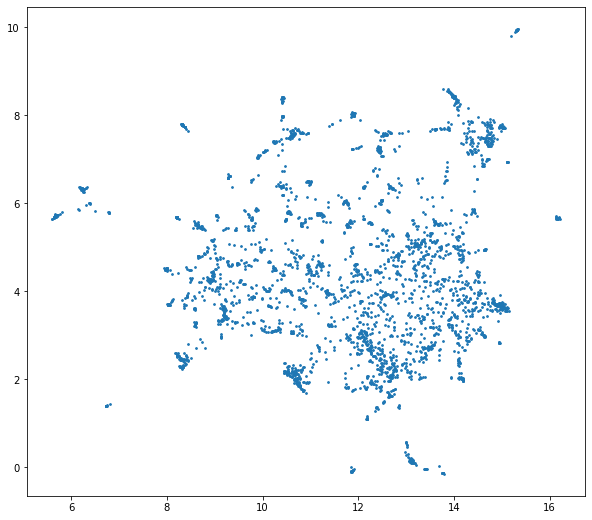

In [19]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these datapoints. These are groups of similar products.

## Start Recommending Products

Congratulations! We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector. 

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [20]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [40]:
products_dict

{'10002': ['INFLATABLE POLITICAL GLOBE '],
 '10080': ['GROOVY CACTUS INFLATABLE'],
 '10120': ['DOGGY RUBBER'],
 '10123C': ['HEARTS WRAPPING TAPE '],
 '10124A': ['SPOTS ON RED BOOKCOVER TAPE'],
 '10124G': ['ARMY CAMO BOOKCOVER TAPE'],
 '10125': ['MINI FUNKY DESIGN TAPES'],
 '10133': ['COLOURING PENCILS BROWN TUBE'],
 '10135': ['COLOURING PENCILS BROWN TUBE'],
 '11001': ['ASSTD DESIGN RACING CAR PEN'],
 '15030': ['FAN BLACK FRAME '],
 '15034': ['PAPER POCKET TRAVELING FAN '],
 '15036': ['ASSORTED COLOURS SILK FAN'],
 '15039': ['SANDALWOOD FAN'],
 '15044A': ['PINK PAPER PARASOL '],
 '15044B': ['BLUE PAPER PARASOL '],
 '15044C': ['PURPLE PAPER PARASOL'],
 '15044D': ['RED PAPER PARASOL'],
 '15056BL': ['EDWARDIAN PARASOL BLACK'],
 '15056N': ['EDWARDIAN PARASOL NATURAL'],
 '15056P': ['EDWARDIAN PARASOL PINK'],
 '15058A': ['BLUE POLKADOT GARDEN PARASOL'],
 '15058B': ['PINK POLKADOT GARDEN PARASOL'],
 '15058C': ['ICE CREAM DESIGN GARDEN PARASOL'],
 '15060B': ['FAIRY CAKE DESIGN UMBRELLA'],
 '16

In [21]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

<br>

I have defined the function below. It will take a product's vector (n) as input and return top 6 similar products.

In [25]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Let's try out our function by passing the vector of the product '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [42]:
products_dict['90019A']

['SILVER M.O.P ORBIT BRACELET']

In [26]:
similar_products(model.wv['90019A'])

[('ANT COPPER RED BOUDICCA BRACELET', 0.8537089228630066),
 ('BLUE MURANO TWIST BRACELET', 0.8457275629043579),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.8218550682067871),
 ('JADE DROP EARRINGS W FILIGREE', 0.8217835426330566),
 ('PINK BOUDICCA LARGE BRACELET', 0.8144066333770752),
 ('GREEN MURANO TWIST BRACELET', 0.8126418590545654)]

<br>

Cool! The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases he or she has made in the past?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [65]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        print(i)
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [31]:
len(purchases_val[0])

64

The length of the first list of products purchased by a user is 314. We will pass this products' sequence of the validation set to the function *aggregate_vectors*.

In [66]:
aggregate_vectors(purchases_val[0]).shape

22961
22943
22617
22569
22568
84032B
84032A
22749
22940
22909
22652
22910
22585
21523
22624
21523
22624
48138
23284
23298
22988
22988
M
22366
21463
21464
22334
21034
22333
10120
16235
22439
21914
21220
21329
20974
21829
23284
23382
22909
22950
22910
22141
22142
23312
22585
22961
22561
23188
22991
22992
23192
84692
23300
84347
84347
23300
23188
22142
22141
23298
22366
23300
23300


(100,)

Well, the function has returned an array of 100 dimension. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [33]:
similar_products(aggregate_vectors(purchases_val[0]))

[('SET OF 20 VINTAGE CHRISTMAS NAPKINS', 0.6552286744117737),
 ('CHRISTMAS CRAFT WHITE FAIRY ', 0.6399833559989929),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6324231624603271),
 ('CHRISTMAS CRAFT TREE TOP ANGEL', 0.6305710673332214),
 ('CHRISTMAS CRAFT LITTLE FRIENDS', 0.6305406093597412),
 ('VINTAGE CHRISTMAS CAKE FRILL', 0.621962308883667)]

As it turns out, our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on the last few purchases only then also you can use the same set of functions.

Below I am giving only the last 10 products purchased as input.

In [34]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('GARDENERS KNEELING PAD KEEP CALM ', 0.7303639650344849),
 ('CHRISTMAS CRAFT WHITE FAIRY ', 0.6774165034294128),
 ('ROTATING SILVER ANGELS T-LIGHT HLDR', 0.6582952737808228),
 ('CHRISTMAS CRAFT LITTLE FRIENDS', 0.6336666345596313),
 ('SET 6 PAPER TABLE LANTERN STARS ', 0.6280423402786255),
 ('CHRISTMAS CRAFT TREE TOP ANGEL', 0.6244160532951355)]

Feel free to play this code, try to get product recommendation for more sequences from the validation set